**Overview**
This project performs multi-label classification of medical conditions using chest radiograph metadata. It compares traditional full fine-tuning against Low-Rank Adaptation (LoRA), a parameter-efficient method that requires significantly fewer trainable parameters.

**System Architecture**
1. Data Layer
- Source: Google BigQuery (MIMIC-CXR-JPG) or synthetic sample generator
- Metadata: dicom_id, subject_id, study_id, view position, image resolution, and CheXpert labels
- Text Feature: Concatenation of metadata fields into a single input string
2. Preprocessing
- Tokenization using Hugging Face tokenizer
- Binarized multi-label representation for 14 medical findings
- Custom PyTorch Dataset for training and evaluation
3. Model Layer

 A. Traditional Fine-Tuning:
    - Full transformer model is trainable
    - Classification head uses

 B. LoRA Fine-Tuning:
    - Transformer layers are frozen
    - LoRA modules are added to attention layers (query/key/value)
    - Only small LoRA matrices and classifier head are trained

4. Training & Evaluation
- Uses Hugging Face Trainer
- Stratified train/test split based on ViewPosition
- Metrics: Precision, Recall, F1, Hamming Loss, Jaccard, Subset Accuracy

5. Visualization & Utilities
- Label distribution heatmaps, training time comparisons, parameter breakdowns
- ModelDeploymentHelper: save/load models
- HyperparameterTuner for LoRA (rank, alpha)
- Clinical severity-based relevance scores

Pros & Cons

Traditional Fine-Tuning

Pros:
- Best performance
- Flexible with full model access

Cons:
- Requires high memory and time
- Not ideal for deployment

LoRA Fine-Tuning

Pros:
- Greater than >95% parameter reduction
- Efficient training
- Edge-device friendly

Cons:
- Slightly lower accuracy
- Requires hyperparameter tuning

📊 Summary


| Criteria             | Traditional FT  | LoRA Fine-Tuning       |
| -------------------- | --------------- | ---------------------- |
| F1 Score             | High (baseline) | Slightly lower (\~95%) |
| Training Time        | Long            | Fast                   |
| Memory/Compute Need  | High            | Very Low               |
| Parameters Trained   | All (\~66M)     | <0.5M                  |
| Clinical Suitability | Good            | Excellent (Edge use)   |
| Flexibility          | Maximum         | Efficient, Tunable     |



**SAMPLE OUTPUTS on 50,000 samples:**
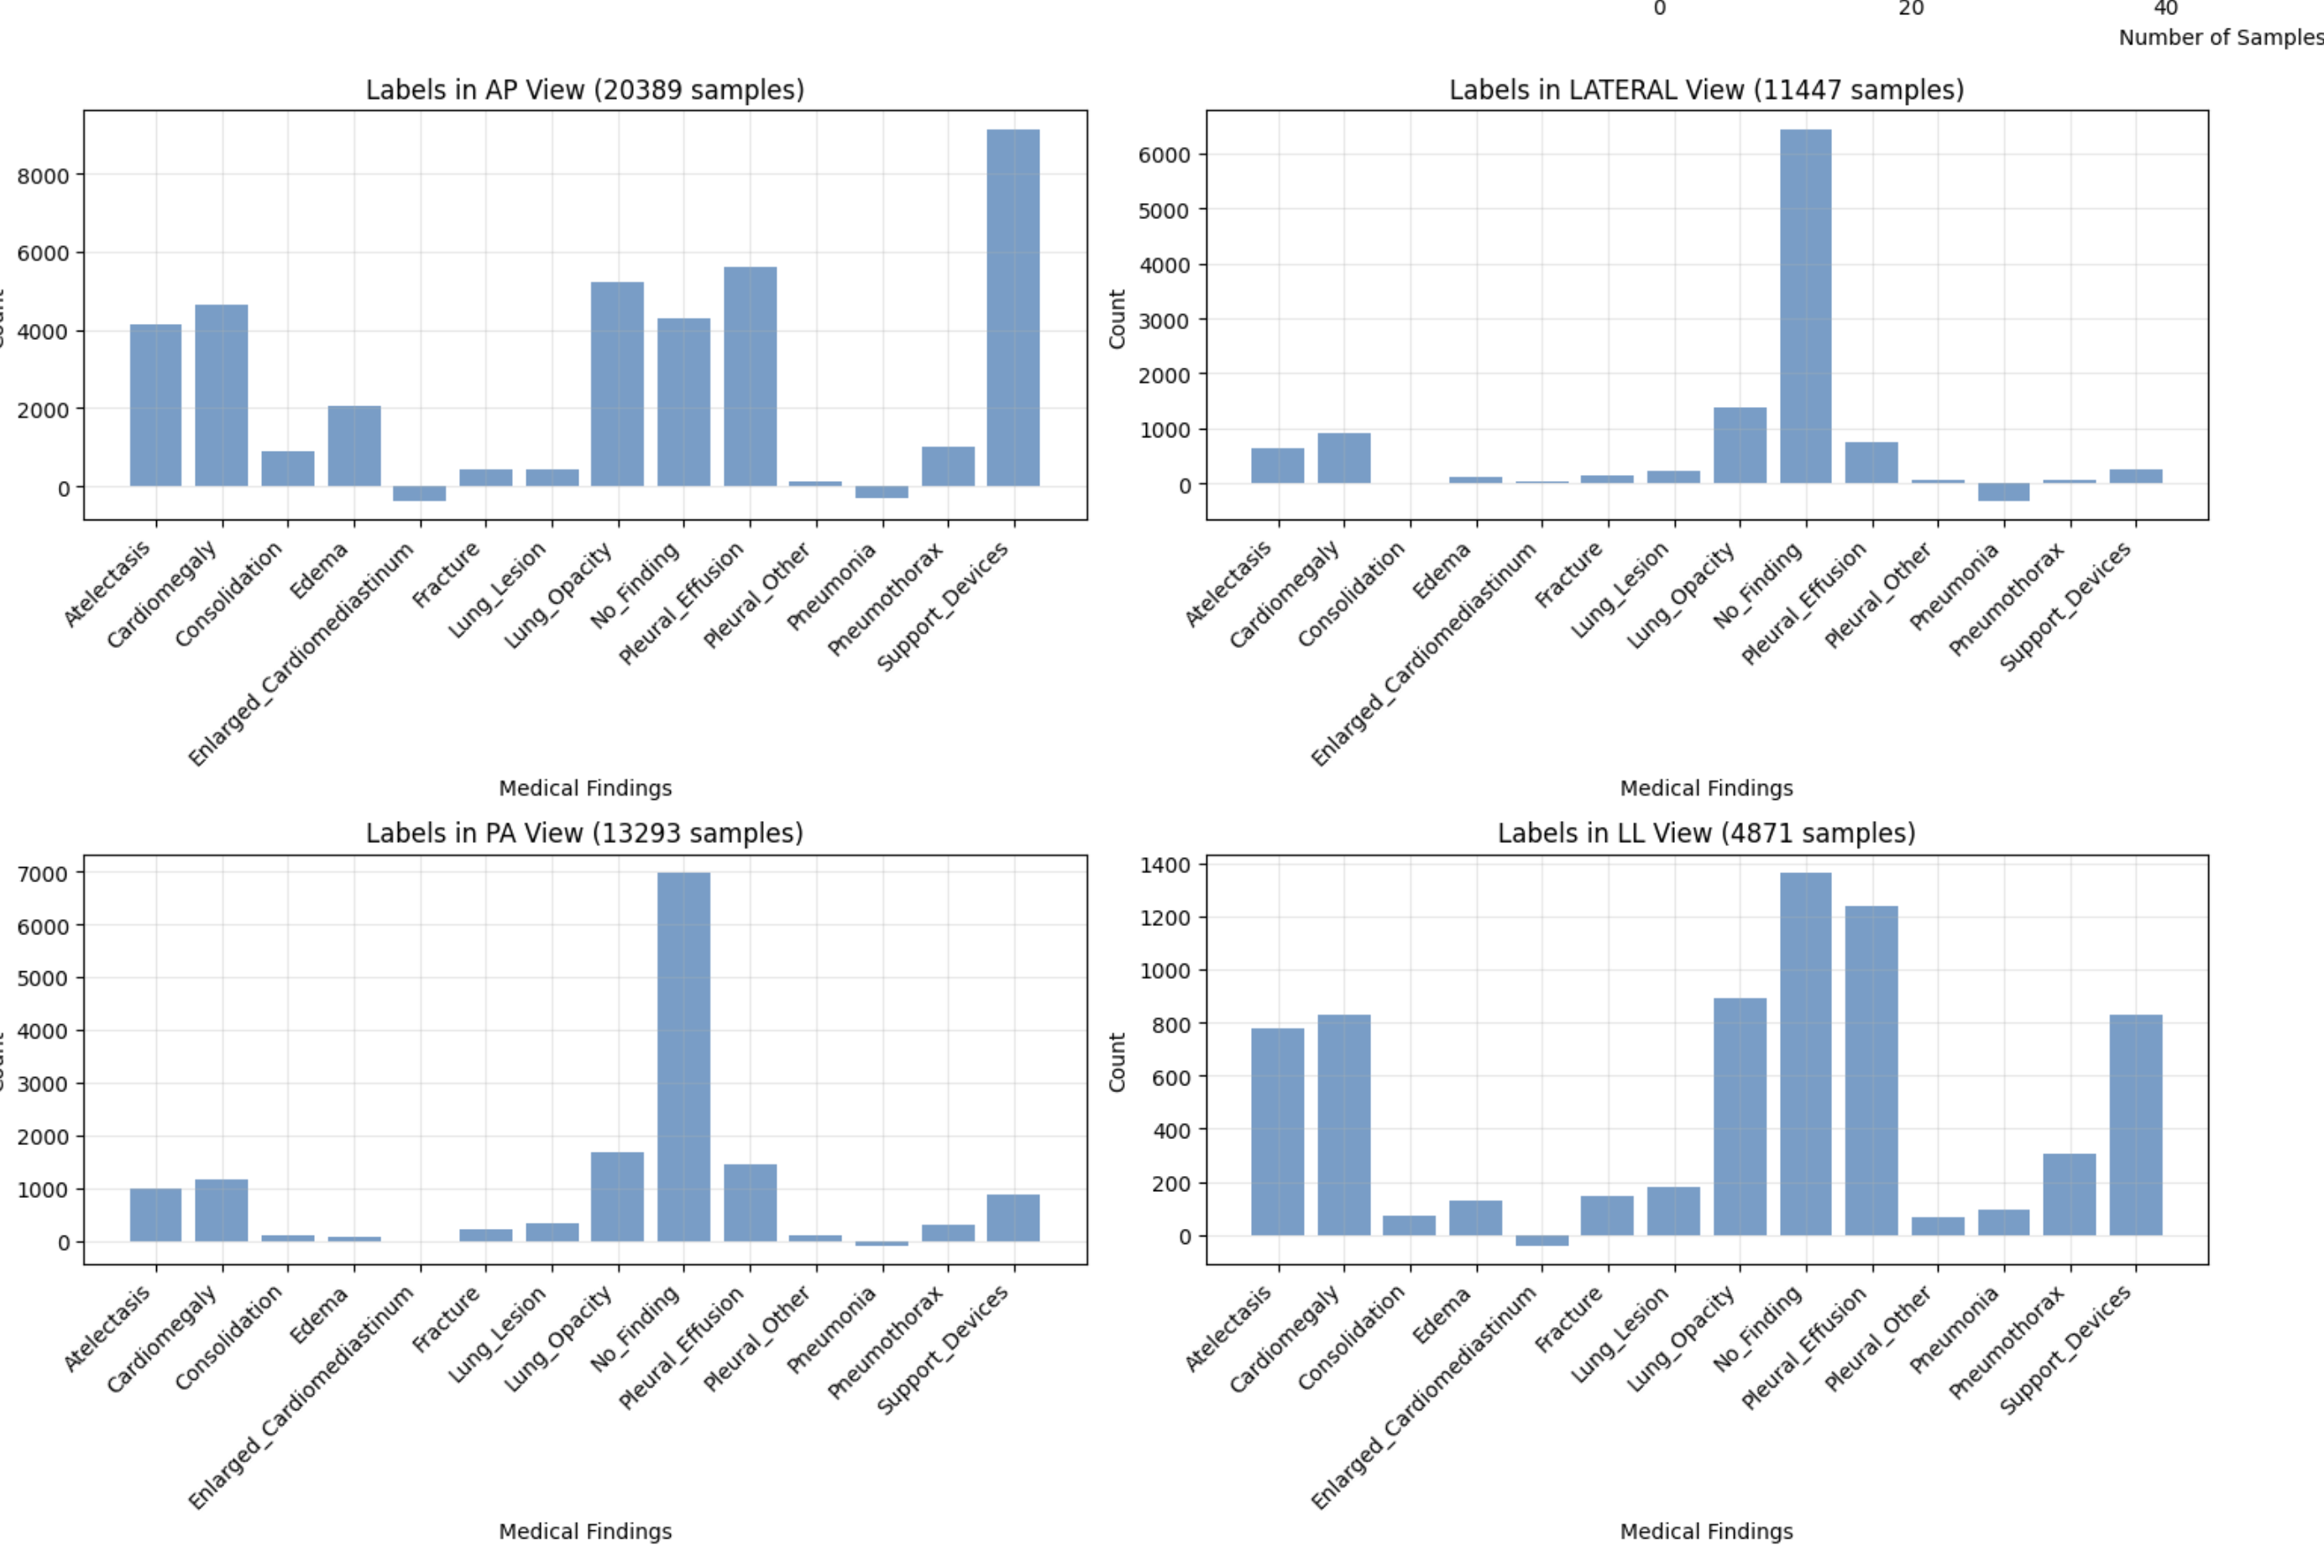

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import json
import time
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# BigQuery imports and setup
try:
    from google.cloud import bigquery, storage
    from google.colab import auth
    BIGQUERY_AVAILABLE = True
except ImportError:
    print("BigQuery not available - using sample data only")
    BIGQUERY_AVAILABLE = False

class EnhancedBigQueryDataLoader:
    """
    Enhanced class to load data from Google Cloud BigQuery with complete metadata
    """
    def __init__(self, project_id: str = 'sampleproject-56290'):
        self.project_id = project_id
        if BIGQUERY_AVAILABLE:
            self.client = bigquery.Client(project=project_id)
        else:
            self.client = None

    def load_data_from_bigquery(self, limit: int = 1000) -> pd.DataFrame:
        """Load data from BigQuery with enhanced metadata fields"""

        if not BIGQUERY_AVAILABLE or self.client is None:
            print("BigQuery not available - using sample data")
            return self.create_enhanced_sample_data(limit)

        # Enhanced query with all metadata fields from the image
        query = f"""
        SELECT
            mt.dicom_id,
            mt.subject_id,
            mt.study_id,
            mt.PerformedProcedureStepDescription,
            mt.ViewPosition,
            mt.Rows,
            mt.Columns,
            mt.ProcedureCodeSequence_CodeMeaning,
            mt.ViewCodeSequence_CodeMeaning,
            mt.PatientOrientationCodeSequence_CodeMeaning,
            cp.Atelectasis,
            cp.Cardiomegaly,
            cp.Consolidation,
            cp.Edema,
            cp.Enlarged_Cardiomediastinum,
            cp.Fracture,
            cp.Lung_Lesion,
            cp.Lung_Opacity,
            cp.No_Finding,
            cp.Pleural_Effusion,
            cp.Pleural_Other,
            cp.Pneumonia,
            cp.Pneumothorax,
            cp.Support_Devices
        FROM `physionet-data.mimic_cxr_jpg.metadata` mt
        JOIN `physionet-data.mimic_cxr_jpg.chexpert` cp
        ON mt.study_id = cp.study_id
        WHERE mt.ViewPosition IS NOT NULL
        AND mt.subject_id IS NOT NULL
        ORDER BY mt.subject_id, mt.ViewPosition
        LIMIT {limit}
        """

        print(f"Executing Enhanced BigQuery query...")
        print(f"Query: {query}")

        try:
            # Execute query and convert to DataFrame
            df = self.client.query(query).to_dataframe()
            print(f"Successfully loaded {len(df)} rows from BigQuery")

            # Display basic info about the dataset
            print(f"\nDataset shape: {df.shape}")
            print(f"Columns: {list(df.columns)}")

            # Handle missing values
            df = self.clean_enhanced_data(df)

            return df

        except Exception as e:
            print(f"Error loading data from BigQuery: {e}")
            print("Falling back to sample data generation...")
            return self.create_enhanced_sample_data(limit)

    def clean_enhanced_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and preprocess the enhanced data"""

        # Fill missing values in text columns
        text_columns = [
            'PerformedProcedureStepDescription',
            'ViewPosition',
            'ProcedureCodeSequence_CodeMeaning',
            'ViewCodeSequence_CodeMeaning',
            'PatientOrientationCodeSequence_CodeMeaning'
        ]

        for col in text_columns:
            if col in df.columns:
                df[col] = df[col].fillna('Unknown')

        # Fill missing values in numeric columns
        numeric_columns = ['Rows', 'Columns']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = df[col].fillna(0).astype(int)

        # Fill missing values in label columns (assume 0 for missing labels)
        label_columns = [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Enlarged_Cardiomediastinum', 'Fracture', 'Lung_Lesion',
            'Lung_Opacity', 'No_Finding', 'Pleural_Effusion',
            'Pleural_Other', 'Pneumonia', 'Pneumothorax', 'Support_Devices'
        ]

        for col in label_columns:
            if col in df.columns:
                df[col] = df[col].fillna(0).astype(int)

        # Create comprehensive text features
        df['enhanced_text'] = self.create_enhanced_text_features(df)

        # Create ViewPosition-based features
        df['viewposition_encoded'] = df['ViewPosition'].astype('category').cat.codes

        # Group data by subject_id and ViewPosition for better analysis
        df['subject_view_key'] = df['subject_id'].astype(str) + '_' + df['ViewPosition'].astype(str)

        print(f"Enhanced data cleaning completed. Shape: {df.shape}")
        print(f"Unique ViewPositions: {df['ViewPosition'].unique()}")
        print(f"Unique subjects: {df['subject_id'].nunique()}")

        return df

    def create_enhanced_text_features(self, df: pd.DataFrame) -> pd.Series:
        """Create comprehensive text features from all metadata fields"""

        text_parts = []

        # Add procedure description
        if 'PerformedProcedureStepDescription' in df.columns:
            text_parts.append(df['PerformedProcedureStepDescription'].fillna(''))

        # Add view position
        if 'ViewPosition' in df.columns:
            text_parts.append(df['ViewPosition'].fillna(''))

        # Add image dimensions as text
        if 'Rows' in df.columns and 'Columns' in df.columns:
            dimensions = df['Rows'].astype(str) + 'x' + df['Columns'].astype(str)
            text_parts.append(dimensions)

        # Add procedure code meaning
        if 'ProcedureCodeSequence_CodeMeaning' in df.columns:
            text_parts.append(df['ProcedureCodeSequence_CodeMeaning'].fillna(''))

        # Add view code meaning
        if 'ViewCodeSequence_CodeMeaning' in df.columns:
            text_parts.append(df['ViewCodeSequence_CodeMeaning'].fillna(''))

        # Add patient orientation
        if 'PatientOrientationCodeSequence_CodeMeaning' in df.columns:
            text_parts.append(df['PatientOrientationCodeSequence_CodeMeaning'].fillna(''))

        # Combine all text parts
        combined_text = pd.Series([' '.join(parts) for parts in zip(*text_parts)])

        return combined_text

    def create_enhanced_sample_data(self, n_samples: int = 1000) -> pd.DataFrame:
        """Create enhanced sample data that matches the complete BigQuery schema"""
        import random

        procedures = [
            "CHEST PA AND LAT", "CHEST PA", "CHEST AP", "CHEST LAT",
            "CHEST PORTABLE AP", "CHEST ICU PORTABLE", "CHEST PA UPRIGHT",
            "CHEST 2 VIEWS", "CHEST SINGLE VIEW", "CHEST LATERAL DECUBITUS"
        ]

        view_positions = ["PA", "LAT", "AP", "LATERAL", "PORTABLE"]

        procedure_codes = [
            "Plain chest X-ray", "Chest radiography", "Thoracic imaging",
            "Pulmonary examination", "Cardiac imaging"
        ]

        view_codes = [
            "Posteroanterior view", "Lateral view", "Anteroposterior view",
            "Oblique view", "Decubitus view"
        ]

        orientations = [
            "Patient upright", "Patient supine", "Patient prone",
            "Patient left lateral", "Patient right lateral"
        ]

        data = []
        subjects_used = set()

        for i in range(n_samples):
            # Generate subject_id (ensuring some subjects have multiple views)
            if random.random() < 0.3 and len(subjects_used) > 0:  # 30% chance to reuse subject
                subject_id = random.choice(list(subjects_used))
            else:
                subject_id = random.randint(10000000, 19999999)
                subjects_used.add(subject_id)

            procedure = random.choice(procedures)
            view_pos = random.choice(view_positions)

            # Image dimensions (typical chest X-ray sizes)
            rows = random.choice([2048, 2560, 3056, 3520])
            columns = random.choice([2048, 2048, 2544, 2816])

            # Generate random labels (ensuring not all are positive)
            labels = {}
            for label in ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                         'Enlarged_Cardiomediastinum', 'Fracture', 'Lung_Lesion',
                         'Lung_Opacity', 'No_Finding', 'Pleural_Effusion',
                         'Pleural_Other', 'Pneumonia', 'Pneumothorax', 'Support_Devices']:
                labels[label] = random.choices([0, 1], weights=[0.8, 0.2])[0]  # 20% chance of positive

            # Ensure at least one finding (either a pathology or No_Finding)
            if sum(labels.values()) == 0:
                labels['No_Finding'] = 1
            elif labels['No_Finding'] == 1 and sum(labels.values()) > 1:
                labels['No_Finding'] = 0  # Can't have No_Finding with other findings

            # Create enhanced text
            enhanced_text = f"{procedure} {view_pos} {rows}x{columns} {random.choice(procedure_codes)} {random.choice(view_codes)} {random.choice(orientations)}"

            data.append({
                'dicom_id': f"dicom_{i:06d}",
                'subject_id': subject_id,
                'study_id': random.randint(50000000, 59999999),
                'PerformedProcedureStepDescription': procedure,
                'ViewPosition': view_pos,
                'Rows': rows,
                'Columns': columns,
                'ProcedureCodeSequence_CodeMeaning': random.choice(procedure_codes),
                'ViewCodeSequence_CodeMeaning': random.choice(view_codes),
                'PatientOrientationCodeSequence_CodeMeaning': random.choice(orientations),
                'enhanced_text': enhanced_text,
                'viewposition_encoded': view_positions.index(view_pos),
                'subject_view_key': f"{subject_id}_{view_pos}",
                **labels
            })

        df = pd.DataFrame(data)
        print(f"Created enhanced sample dataset with {len(df)} rows")
        print(f"Unique subjects: {df['subject_id'].nunique()}")
        print(f"ViewPositions: {df['ViewPosition'].value_counts().to_dict()}")
        return df

    def analyze_data_distribution(self, df: pd.DataFrame) -> Dict:
        """Analyze the distribution of data by ViewPosition and subject_id"""

        analysis = {
            'total_samples': len(df),
            'unique_subjects': df['subject_id'].nunique(),
            'viewposition_distribution': df['ViewPosition'].value_counts().to_dict(),
            'subjects_per_viewposition': {},
            'labels_per_viewposition': {},
            'average_labels_per_sample': df[self.get_label_columns()].sum(axis=1).mean()
        }

        # Analyze subjects per view position
        for view_pos in df['ViewPosition'].unique():
            view_data = df[df['ViewPosition'] == view_pos]
            analysis['subjects_per_viewposition'][view_pos] = view_data['subject_id'].nunique()

        # Analyze label distribution per view position
        label_columns = self.get_label_columns()
        for view_pos in df['ViewPosition'].unique():
            view_data = df[df['ViewPosition'] == view_pos]
            analysis['labels_per_viewposition'][view_pos] = view_data[label_columns].sum().to_dict()

        return analysis

    def get_label_columns(self) -> List[str]:
        """Get the 14 label columns"""
        return [
            'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
            'Enlarged_Cardiomediastinum', 'Fracture', 'Lung_Lesion',
            'Lung_Opacity', 'No_Finding', 'Pleural_Effusion',
            'Pleural_Other', 'Pneumonia', 'Pneumothorax', 'Support_Devices'
        ]

# Enhanced LoRA Implementation (same as before but with better naming)
class LoRALayer(nn.Module):
    """LoRA (Low-Rank Adaptation) layer implementation"""
    def __init__(self, in_features: int, out_features: int, rank: int = 8, alpha: float = 16.0):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank

        # LoRA matrices
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))

    def forward(self, x):
        return (x @ self.lora_A.T @ self.lora_B.T) * self.scaling

class LoRALinear(nn.Module):
    """Linear layer with LoRA adaptation"""
    def __init__(self, original_layer: nn.Linear, rank: int = 8, alpha: float = 16.0):
        super().__init__()
        self.original_layer = original_layer
        self.lora = LoRALayer(
            original_layer.in_features,
            original_layer.out_features,
            rank,
            alpha
        )

        # Freeze original parameters
        for param in self.original_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.original_layer(x) + self.lora(x)

# Enhanced Multi-label Classification Models
class EnhancedMultiLabelClassifier(nn.Module):
    """Enhanced multi-label text classifier with metadata integration"""
    def __init__(self, model_name: str, num_labels: int, dropout_rate: float = 0.1):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits}

class EnhancedLoRAMultiLabelClassifier(nn.Module):
    """Enhanced multi-label text classifier with LoRA adaptation"""
    def __init__(self, model_name: str, num_labels: int, rank: int = 8, alpha: float = 16.0, dropout_rate: float = 0.1):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.model_name = model_name.lower()

        # Freeze transformer parameters
        for param in self.transformer.parameters():
            param.requires_grad = False

        # Apply LoRA to attention layers
        self.apply_lora_to_attention(rank, alpha)

        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def apply_lora_to_attention(self, rank: int, alpha: float):
        """Apply LoRA to transformer attention layers - handles different architectures"""
        try:
            if 'distilbert' in self.model_name:
                layers = self.transformer.transformer.layer
                for layer in layers:
                    layer.attention.q_lin = LoRALinear(layer.attention.q_lin, rank, alpha)
                    layer.attention.k_lin = LoRALinear(layer.attention.k_lin, rank, alpha)
                    layer.attention.v_lin = LoRALinear(layer.attention.v_lin, rank, alpha)

            elif 'bert' in self.model_name:
                layers = self.transformer.encoder.layer
                for layer in layers:
                    layer.attention.self.query = LoRALinear(layer.attention.self.query, rank, alpha)
                    layer.attention.self.key = LoRALinear(layer.attention.self.key, rank, alpha)
                    layer.attention.self.value = LoRALinear(layer.attention.self.value, rank, alpha)

            elif 'roberta' in self.model_name:
                layers = self.transformer.encoder.layer
                for layer in layers:
                    layer.attention.self.query = LoRALinear(layer.attention.self.query, rank, alpha)
                    layer.attention.self.key = LoRALinear(layer.attention.self.key, rank, alpha)
                    layer.attention.self.value = LoRALinear(layer.attention.self.value, rank, alpha)

            else:
                print(f"Warning: Unknown model architecture for {self.model_name}")
                print("LoRA will only be applied to the classification head")

        except AttributeError as e:
            print(f"Error applying LoRA to attention layers: {e}")
            print("LoRA will only be applied to the classification head")

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())

        return {"loss": loss, "logits": logits}

# Enhanced Dataset class
class EnhancedMultiLabelDataset(Dataset):
    """Enhanced dataset class for multi-label text classification with metadata"""
    def __init__(self, texts: List[str], labels: np.ndarray, tokenizer, max_length: int = 512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Enhanced Training and Evaluation
class EnhancedMultiLabelTrainer:
    """Enhanced trainer class for multi-label classification with comprehensive analysis"""
    def __init__(self, model_name: str = "distilbert-base-uncased", max_length: int = 256):
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def prepare_data(self, df: pd.DataFrame, text_column: str, label_columns: List[str],
                    test_size: float = 0.2, stratify_by: str = None) -> Tuple:
        """Prepare data for training and testing with enhanced stratification"""
        texts = df[text_column].tolist()
        labels = df[label_columns].values

        # Enhanced label distribution analysis
        print("Enhanced Label Distribution Analysis:")
        for i, col in enumerate(label_columns):
            pos_count = sum(labels[:, i])
            print(f"  {col}: {pos_count}/{len(labels)} ({pos_count/len(labels)*100:.1f}%)")

        # Analyze by ViewPosition if available
        if 'ViewPosition' in df.columns:
            print("\nLabel Distribution by ViewPosition:")
            for view_pos in df['ViewPosition'].unique():
                view_mask = df['ViewPosition'] == view_pos
                view_labels = labels[view_mask]
                print(f"  {view_pos} ({view_mask.sum()} samples):")
                for i, col in enumerate(label_columns):
                    pos_count = sum(view_labels[:, i])
                    if view_mask.sum() > 0:
                        print(f"    {col}: {pos_count}/{view_mask.sum()} ({pos_count/view_mask.sum()*100:.1f}%)")

        # Enhanced stratified split
        if stratify_by and stratify_by in df.columns:
            # Create stratification labels
            stratify_labels = df[stratify_by].values
            X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
                texts, labels, stratify_labels, test_size=test_size,
                random_state=42, stratify=stratify_labels
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                texts, labels, test_size=test_size, random_state=42
            )

        # Create datasets
        train_dataset = EnhancedMultiLabelDataset(X_train, y_train, self.tokenizer, self.max_length)
        test_dataset = EnhancedMultiLabelDataset(X_test, y_test, self.tokenizer, self.max_length)

        return train_dataset, test_dataset, len(label_columns)

    def train_traditional_model(self, train_dataset, test_dataset, num_labels: int,
                              epochs: int = 3, batch_size: int = 8) -> Tuple:
        """Train traditional fine-tuning model"""
        print("Training Enhanced Traditional Fine-tuning Model...")

        model = EnhancedMultiLabelClassifier(self.model_name, num_labels)
        model.to(self.device)

        training_args_dict = {
            'output_dir': './enhanced_traditional_results',
            'num_train_epochs': epochs,
            'per_device_train_batch_size': batch_size,
            'per_device_eval_batch_size': batch_size,
            'learning_rate': 2e-5,
            'warmup_steps': 50,
            'weight_decay': 0.01,
            'logging_dir': './enhanced_traditional_logs',
            'logging_steps': 25,
            'eval_steps': 100,
            'save_strategy': "no",
            'load_best_model_at_end': False,
            'dataloader_pin_memory': False,
            'gradient_accumulation_steps': 1,
            'report_to': "none",
            'disable_tqdm': False,
            'fp16': False,
        }

        try:
            training_args_dict['eval_strategy'] = "steps"
            training_args = TrainingArguments(**training_args_dict)
        except TypeError:
            training_args_dict.pop('eval_strategy', None)
            training_args_dict['evaluation_strategy'] = "steps"
            training_args = TrainingArguments(**training_args_dict)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )

        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time

        print(f"Enhanced traditional model training completed in {training_time:.2f} seconds")

        self._check_model_learning(model, train_dataset, "Enhanced Traditional")

        return model, trainer, training_time

    def train_lora_model(self, train_dataset, test_dataset, num_labels: int,
                        rank: int = 8, alpha: float = 16.0, epochs: int = 3,
                        batch_size: int = 8) -> Tuple:
        """Train enhanced LoRA model"""
        print("Training Enhanced LoRA Model...")

        model = EnhancedLoRAMultiLabelClassifier(self.model_name, num_labels, rank, alpha)
        model.to(self.device)

        training_args_dict = {
            'output_dir': './enhanced_lora_results',
            'num_train_epochs': epochs,
            'per_device_train_batch_size': batch_size,
            'per_device_eval_batch_size': batch_size,
            'learning_rate': 1e-4,
            'warmup_steps': 50,
            'weight_decay': 0.01,
            'logging_dir': './enhanced_lora_logs',
            'logging_steps': 25,
            'eval_steps': 100,
            'save_strategy': "no",
            'load_best_model_at_end': False,
            'dataloader_pin_memory': False,
            'gradient_accumulation_steps': 1,
            'report_to': "none",
            'disable_tqdm': False,
            'fp16': False,
        }

        try:
            training_args_dict['eval_strategy'] = "steps"
            training_args = TrainingArguments(**training_args_dict)
        except TypeError:
            training_args_dict.pop('eval_strategy', None)
            training_args_dict['evaluation_strategy'] = "steps"
            training_args = TrainingArguments(**training_args_dict)

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )

        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time

        print(f"Enhanced LoRA model training completed in {training_time:.2f} seconds")

        self._check_model_learning(model, train_dataset, "Enhanced LoRA")

        return model, trainer, training_time

    def _check_model_learning(self, model, train_dataset, model_name: str):
        """Check if model actually learned by testing on a few training samples"""
        model.eval()
        test_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

        with torch.no_grad():
            batch = next(iter(test_loader))
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.sigmoid(outputs['logits']).cpu().numpy()

            print(f"{model_name} model check:")
            print(f"  Probability range: [{probabilities.min():.4f}, {probabilities.max():.4f}]")
            print(f"  Mean probability: {probabilities.mean():.4f}")
            print(f"  Std probability: {probabilities.std():.4f}")

            if probabilities.max() < 0.1:
                print(f"  WARNING: {model_name} model probabilities very low - may not be learning")
            elif probabilities.min() > 0.9:
                print(f"  WARNING: {model_name} model probabilities very high - may be overfitting")

    def evaluate_model(self, model, test_dataset, model_name: str) -> Dict:
        """Evaluate model performance for multi-label classification"""
        model.eval()
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

        all_predictions = []
        all_labels = []
        all_probabilities = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].cpu().numpy()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probabilities = torch.sigmoid(outputs['logits']).cpu().numpy()

                all_probabilities.append(probabilities)
                all_labels.append(labels)

        # Concatenate all batches
        all_probabilities = np.concatenate(all_probabilities, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        print(f"Debug - Labels shape: {all_labels.shape}")
        print(f"Debug - Probabilities shape: {all_probabilities.shape}")
        print(f"Debug - Probability range: [{all_probabilities.min():.4f}, {all_probabilities.max():.4f}]")

        # Use adaptive threshold
        if all_probabilities.std() < 0.01:
            threshold = np.median(all_probabilities)
            threshold = max(0.1, min(0.9, threshold))
        else:
            threshold = 0.5

        print(f"Using threshold: {threshold:.4f}")

        # Convert to binary predictions
        binary_predictions = (all_probabilities > threshold).astype(int)
        all_labels = all_labels.astype(int)

        # Handle the case where all predictions are zeros
        if binary_predictions.sum() == 0:
            print("WARNING: All predictions are zero. Using top-k prediction strategy.")
            for i in range(len(binary_predictions)):
                max_idx = np.argmax(all_probabilities[i])
                binary_predictions[i, max_idx] = 1

        # Calculate comprehensive metrics
        try:
            n_samples, n_labels = all_labels.shape

            # Per-sample metrics
            sample_accuracies = []
            sample_precisions = []
            sample_recalls = []
            sample_f1s = []

            for i in range(n_samples):
                y_true = all_labels[i]
                y_pred = binary_predictions[i]

                if y_true.sum() == 0 and y_pred.sum() == 0:
                    sample_accuracies.append(1.0)
                    sample_precisions.append(1.0)
                    sample_recalls.append(1.0)
                    sample_f1s.append(1.0)
                elif y_pred.sum() == 0:
                    sample_accuracies.append(0.0)
                    sample_precisions.append(0.0)
                    sample_recalls.append(0.0)
                    sample_f1s.append(0.0)
                elif y_true.sum() == 0:
                    sample_accuracies.append(0.0)
                    sample_precisions.append(0.0)
                    sample_recalls.append(0.0)
                    sample_f1s.append(0.0)
                else:
                    intersection = (y_true & y_pred).sum()
                    union = (y_true | y_pred).sum()

                    precision = intersection / y_pred.sum() if y_pred.sum() > 0 else 0.0
                    recall = intersection / y_true.sum() if y_true.sum() > 0 else 0.0
                    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
                    accuracy = intersection / union if union > 0 else 1.0

                    sample_accuracies.append(accuracy)
                    sample_precisions.append(precision)
                    sample_recalls.append(recall)
                    sample_f1s.append(f1)

            # Average across samples
            precision = np.mean(sample_precisions)
            recall = np.mean(sample_recalls)
            f1 = np.mean(sample_f1s)
            jaccard_avg = np.mean(sample_accuracies)

            # Hamming loss
            hamming = np.mean(all_labels != binary_predictions)

            # Subset accuracy (exact match)
            subset_accuracy = np.mean([np.array_equal(all_labels[i], binary_predictions[i])
                                     for i in range(n_samples)])

            # Try sklearn metrics as backup
            try:
                precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
                    all_labels, binary_predictions, average='macro', zero_division=0
                )
                f1_sklearn = f1_macro
            except:
                f1_sklearn = f1

            print(f"Evaluation Results for {model_name}:")
            print(f"  Hamming Loss: {hamming:.4f}")
            print(f"  Sample-avg F1: {f1:.4f}")
            print(f"  Sklearn F1: {f1_sklearn:.4f}")
            print(f"  Subset Accuracy: {subset_accuracy:.4f}")
            print(f"  Jaccard Score: {jaccard_avg:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")

        except Exception as e:
            print(f"Error in evaluation: {e}")
            element_accuracy = np.mean(all_labels == binary_predictions)
            hamming = 1 - element_accuracy
            precision = recall = f1 = f1_sklearn = element_accuracy
            subset_accuracy = element_accuracy
            jaccard_avg = element_accuracy

        metrics = {
            'model': model_name,
            'hamming_loss': hamming,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'f1_macro': f1_sklearn if 'f1_sklearn' in locals() else f1,
            'subset_accuracy': subset_accuracy,
            'jaccard_score': jaccard_avg
        }

        return metrics

    def count_parameters(self, model) -> Dict:
        """Count trainable and total parameters"""
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'trainable_percentage': (trainable_params / total_params) * 100
        }

# Enhanced Visualization and Comparison
class EnhancedResultsVisualizer:
    """Enhanced class to visualize and compare results with metadata analysis"""

    @staticmethod
    def plot_enhanced_comparison(traditional_metrics: Dict, lora_metrics: Dict,
                               traditional_time: float, lora_time: float,
                               traditional_params: Dict, lora_params: Dict,
                               data_analysis: Dict = None):
        """Plot comprehensive comparison with enhanced visualizations"""

        plt.style.use('default')
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))

        # Metrics comparison
        metrics = ['precision', 'recall', 'f1_score', 'subset_accuracy']
        traditional_values = [traditional_metrics[m] for m in metrics]
        lora_values = [lora_metrics[m] for m in metrics]

        x = np.arange(len(metrics))
        width = 0.35

        axes[0, 0].bar(x - width/2, traditional_values, width, label='Traditional', alpha=0.8, color='skyblue')
        axes[0, 0].bar(x + width/2, lora_values, width, label='LoRA', alpha=0.8, color='lightcoral')
        axes[0, 0].set_xlabel('Metrics')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Performance Metrics Comparison')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(metrics, rotation=45)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Hamming Loss comparison
        axes[0, 1].bar(['Traditional', 'LoRA'],
                      [traditional_metrics['hamming_loss'], lora_metrics['hamming_loss']],
                      color=['orange', 'green'], alpha=0.7)
        axes[0, 1].set_ylabel('Hamming Loss')
        axes[0, 1].set_title('Hamming Loss Comparison (Lower is Better)')
        axes[0, 1].grid(True, alpha=0.3)

        # Training time comparison
        axes[0, 2].bar(['Traditional', 'LoRA'], [traditional_time, lora_time],
                      color=['red', 'blue'], alpha=0.7)
        axes[0, 2].set_ylabel('Training Time (seconds)')
        axes[0, 2].set_title('Training Time Comparison')
        axes[0, 2].grid(True, alpha=0.3)

        # Parameter comparison
        models = ['Traditional', 'LoRA']
        total_params = [traditional_params['total_parameters']/1e6, lora_params['total_parameters']/1e6]
        trainable_params = [traditional_params['trainable_parameters']/1e6, lora_params['trainable_parameters']/1e6]

        x = np.arange(len(models))
        axes[1, 0].bar(x - width/2, total_params, width, label='Total Parameters', alpha=0.8, color='purple')
        axes[1, 0].bar(x + width/2, trainable_params, width, label='Trainable Parameters', alpha=0.8, color='orange')
        axes[1, 0].set_xlabel('Model')
        axes[1, 0].set_ylabel('Parameters (Millions)')
        axes[1, 0].set_title('Parameter Count Comparison')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(models)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Trainable percentage
        axes[1, 1].bar(models,
                      [traditional_params['trainable_percentage'], lora_params['trainable_percentage']],
                      color=['purple', 'orange'], alpha=0.7)
        axes[1, 1].set_ylabel('Trainable Parameters (%)')
        axes[1, 1].set_title('Percentage of Trainable Parameters')
        axes[1, 1].grid(True, alpha=0.3)

        # Data distribution by ViewPosition (if available)
        if data_analysis and 'viewposition_distribution' in data_analysis:
            view_positions = list(data_analysis['viewposition_distribution'].keys())
            view_counts = list(data_analysis['viewposition_distribution'].values())

            axes[1, 2].pie(view_counts, labels=view_positions, autopct='%1.1f%%')
            axes[1, 2].set_title('Data Distribution by ViewPosition')
        else:
            axes[1, 2].text(0.5, 0.5, 'ViewPosition\nData Not Available',
                           ha='center', va='center', transform=axes[1, 2].transAxes)
            axes[1, 2].set_title('ViewPosition Distribution')

        # Summary table
        axes[2, 0].axis('tight')
        axes[2, 0].axis('off')

        summary_data = [
            ['Metric', 'Traditional', 'LoRA', 'Winner'],
            ['F1 Score', f"{traditional_metrics['f1_score']:.4f}", f"{lora_metrics['f1_score']:.4f}",
             'LoRA' if lora_metrics['f1_score'] > traditional_metrics['f1_score'] else 'Traditional'],
            ['Training Time (s)', f"{traditional_time:.1f}", f"{lora_time:.1f}",
             'LoRA' if lora_time < traditional_time else 'Traditional'],
            ['Trainable Params (M)', f"{traditional_params['trainable_parameters']/1e6:.1f}",
             f"{lora_params['trainable_parameters']/1e6:.1f}", 'LoRA'],
            ['Memory Efficiency', 'Lower', 'Higher', 'LoRA']
        ]

        table = axes[2, 0].table(cellText=summary_data[1:], colLabels=summary_data[0],
                                cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        axes[2, 0].set_title('Summary Comparison')

        # Model efficiency radar chart
        if 'f1_score' in traditional_metrics and 'f1_score' in lora_metrics:
            categories = ['Performance', 'Speed', 'Memory\nEfficiency', 'Parameter\nEfficiency']

            # Normalize metrics for radar chart
            trad_perf = traditional_metrics['f1_score']
            lora_perf = lora_metrics['f1_score']

            trad_speed = min(lora_time / traditional_time, 2.0)  # Cap at 2x
            lora_speed = 1.0

            trad_memory = 0.3  # Assume traditional uses more memory
            lora_memory = 1.0

            trad_param_eff = lora_params['trainable_percentage'] / traditional_params['trainable_percentage']
            lora_param_eff = 1.0

            trad_values = [trad_perf, trad_speed, trad_memory, trad_param_eff]
            lora_values = [lora_perf, lora_speed, lora_memory, lora_param_eff]

            angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle

            trad_values += trad_values[:1]
            lora_values += lora_values[:1]

            axes[2, 1].plot(angles, trad_values, 'o-', linewidth=2, label='Traditional', color='skyblue')
            axes[2, 1].fill(angles, trad_values, alpha=0.25, color='skyblue')
            axes[2, 1].plot(angles, lora_values, 'o-', linewidth=2, label='LoRA', color='lightcoral')
            axes[2, 1].fill(angles, lora_values, alpha=0.25, color='lightcoral')

            axes[2, 1].set_xticks(angles[:-1])
            axes[2, 1].set_xticklabels(categories)
            axes[2, 1].set_ylim(0, 1.2)
            axes[2, 1].set_title('Model Efficiency Comparison')
            axes[2, 1].legend()
            axes[2, 1].grid(True)

        # Dataset statistics
        if data_analysis:
            axes[2, 2].axis('tight')
            axes[2, 2].axis('off')

            stats_data = [
                ['Dataset Statistics', 'Value'],
                ['Total Samples', f"{data_analysis.get('total_samples', 'N/A'):,}"],
                ['Unique Subjects', f"{data_analysis.get('unique_subjects', 'N/A'):,}"],
                ['Avg Labels/Sample', f"{data_analysis.get('average_labels_per_sample', 0):.2f}"],
                ['ViewPositions', f"{len(data_analysis.get('viewposition_distribution', {}))}"
                ]
            ]

            stats_table = axes[2, 2].table(cellText=stats_data[1:], colLabels=stats_data[0],
                                          cellLoc='center', loc='center')
            stats_table.auto_set_font_size(False)
            stats_table.set_fontsize(9)
            stats_table.scale(1.2, 1.5)
            axes[2, 2].set_title('Dataset Statistics')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_enhanced_label_distribution(df: pd.DataFrame, label_columns: List[str]):
        """Plot enhanced distribution of labels with ViewPosition breakdown"""
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))

        # Overall label distribution
        label_counts = df[label_columns].sum()
        colors = plt.cm.Set3(np.linspace(0, 1, len(label_columns)))

        bars = axes[0, 0].bar(label_columns, label_counts, color=colors, alpha=0.8)
        axes[0, 0].set_title('Overall Medical Finding Label Distribution')
        axes[0, 0].set_xlabel('Medical Findings')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].grid(True, alpha=0.3)

        for bar, count in zip(bars, label_counts):
            height = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{int(count)}', ha='center', va='bottom')

        axes[0, 0].tick_params(axis='x', rotation=45)

        # Label distribution by ViewPosition
        if 'ViewPosition' in df.columns:
            view_positions = df['ViewPosition'].unique()

            # Heatmap of labels by view position
            heatmap_data = []
            for view_pos in view_positions:
                view_data = df[df['ViewPosition'] == view_pos]
                view_label_counts = view_data[label_columns].sum().values
                heatmap_data.append(view_label_counts)

            heatmap_data = np.array(heatmap_data)

            im = axes[0, 1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
            axes[0, 1].set_title('Label Distribution Heatmap by ViewPosition')
            axes[0, 1].set_xlabel('Medical Findings')
            axes[0, 1].set_ylabel('ViewPosition')
            axes[0, 1].set_xticks(range(len(label_columns)))
            axes[0, 1].set_xticklabels(label_columns, rotation=45)
            axes[0, 1].set_yticks(range(len(view_positions)))
            axes[0, 1].set_yticklabels(view_positions)

            # Add colorbar
            plt.colorbar(im, ax=axes[0, 1])

            # ViewPosition distribution
            view_counts = df['ViewPosition'].value_counts()
            axes[1, 0].pie(view_counts.values, labels=view_counts.index, autopct='%1.1f%%')
            axes[1, 0].set_title('Distribution of ViewPositions')

        # Subject distribution analysis
        if 'subject_id' in df.columns:
            subject_counts = df['subject_id'].value_counts()
            axes[1, 1].hist(subject_counts.values, bins=20, alpha=0.7, color='lightblue')
            axes[1, 1].set_title('Distribution of Samples per Subject')
            axes[1, 1].set_xlabel('Number of Samples per Subject')
            axes[1, 1].set_ylabel('Number of Subjects')
            axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_viewposition_analysis(df: pd.DataFrame, label_columns: List[str]):
        """Detailed analysis of labels by ViewPosition"""
        if 'ViewPosition' not in df.columns:
            print("ViewPosition column not found in data")
            return

        view_positions = df['ViewPosition'].unique()
        n_positions = len(view_positions)

        fig, axes = plt.subplots(2, (n_positions + 1) // 2, figsize=(15, 10))
        if n_positions == 1:
            axes = [axes]
        axes = axes.flatten() if n_positions > 2 else axes

        for i, view_pos in enumerate(view_positions):
            if i >= len(axes):
                break

            view_data = df[df['ViewPosition'] == view_pos]
            label_counts = view_data[label_columns].sum()

            axes[i].bar(range(len(label_columns)), label_counts.values, alpha=0.7)
            axes[i].set_title(f'Labels in {view_pos} View ({len(view_data)} samples)')
            axes[i].set_xlabel('Medical Findings')
            axes[i].set_ylabel('Count')
            axes[i].set_xticks(range(len(label_columns)))
            axes[i].set_xticklabels(label_columns, rotation=45, ha='right')
            axes[i].grid(True, alpha=0.3)

        # Hide empty subplots
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

# Main execution function with enhanced BigQuery integration
def run_enhanced_multilabel_comparison(project_id: str = 'sampleproject-56290',
                                     limit: int = 1000, use_sample_data: bool = False):
    """
    Main function to run the enhanced comparison with comprehensive metadata analysis
    """

    print("=" * 80)
    print("ENHANCED MULTI-LABEL MEDICAL TEXT CLASSIFICATION: LoRA vs Traditional")
    print("With ViewPosition and Subject-based Analysis")
    print("=" * 80)

    # Step 1: Setup authentication for BigQuery
    if BIGQUERY_AVAILABLE and not use_sample_data:
        try:
            print("Authenticating with Google Cloud...")
            auth.authenticate_user()
            print("Authentication successful!")
        except Exception as e:
            print(f"Authentication failed: {e}")
            print("Falling back to sample data generation...")
            use_sample_data = True
    else:
        use_sample_data = True

    # Step 2: Load enhanced data
    print("\n" + "=" * 50)
    print("STEP 1: ENHANCED DATA LOADING")
    print("=" * 50)

    data_loader = EnhancedBigQueryDataLoader(project_id)

    if use_sample_data:
        df = data_loader.create_enhanced_sample_data(limit)
    else:
        df = data_loader.load_data_from_bigquery(limit)

    # Get label columns
    label_columns = data_loader.get_label_columns()

    print(f"\nEnhanced Dataset Summary:")
    print(f"- Total samples: {len(df)}")
    print(f"- Features: {df.shape[1]}")
    print(f"- Labels: {len(label_columns)}")
    print(f"- Unique subjects: {df['subject_id'].nunique()}")
    print(f"- ViewPositions: {df['ViewPosition'].unique()}")

    # Step 3: Analyze data distribution
    print("\n" + "=" * 50)
    print("STEP 2: COMPREHENSIVE DATA ANALYSIS")
    print("=" * 50)

    data_analysis = data_loader.analyze_data_distribution(df)

    print("Data Distribution Analysis:")
    print(f"- Total samples: {data_analysis['total_samples']}")
    print(f"- Unique subjects: {data_analysis['unique_subjects']}")
    print(f"- Average labels per sample: {data_analysis['average_labels_per_sample']:.2f}")

    print("\nViewPosition Distribution:")
    for view_pos, count in data_analysis['viewposition_distribution'].items():
        print(f"  {view_pos}: {count} samples")

    print("\nSubjects per ViewPosition:")
    for view_pos, count in data_analysis['subjects_per_viewposition'].items():
        print(f"  {view_pos}: {count} unique subjects")

    # Step 4: Enhanced visualizations
    print("\n" + "=" * 50)
    print("STEP 3: ENHANCED DATA VISUALIZATION")
    print("=" * 50)

    EnhancedResultsVisualizer.plot_enhanced_label_distribution(df, label_columns)
    EnhancedResultsVisualizer.plot_viewposition_analysis(df, label_columns)

    # Step 5: Initialize enhanced trainer
    print("\n" + "=" * 50)
    print("STEP 4: ENHANCED MODEL SETUP")
    print("=" * 50)

    trainer = EnhancedMultiLabelTrainer(
        model_name="distilbert-base-uncased",
        max_length=128
    )

    # Step 6: Prepare enhanced data with stratification
    train_dataset, test_dataset, num_labels = trainer.prepare_data(
        df, 'enhanced_text', label_columns, test_size=0.2, stratify_by='ViewPosition'
    )

    print(f"\nEnhanced Data Preparation:")
    print(f"- Training samples: {len(train_dataset)}")
    print(f"- Test samples: {len(test_dataset)}")
    print(f"- Number of labels: {num_labels}")

    # Step 7: Train Traditional Model
    print("\n" + "=" * 50)
    print("STEP 5: ENHANCED TRADITIONAL FINE-TUNING")
    print("=" * 50)

    traditional_model, traditional_trainer, traditional_time = trainer.train_traditional_model(
        train_dataset, test_dataset, num_labels, epochs=3, batch_size=8
    )

    # Step 8: Train LoRA Model
    print("\n" + "=" * 50)
    print("STEP 6: ENHANCED LoRA FINE-TUNING")
    print("=" * 50)

    lora_model, lora_trainer, lora_time = trainer.train_lora_model(
        train_dataset, test_dataset, num_labels,
        rank=8, alpha=16.0, epochs=3, batch_size=8
    )

    # Step 9: Enhanced Model Evaluation
    print("\n" + "=" * 50)
    print("STEP 7: ENHANCED MODEL EVALUATION")
    print("=" * 50)

    print("Evaluating Enhanced Traditional Model...")
    traditional_metrics = trainer.evaluate_model(traditional_model, test_dataset, "Enhanced Traditional")

    print("Evaluating Enhanced LoRA Model...")
    lora_metrics = trainer.evaluate_model(lora_model, test_dataset, "Enhanced LoRA")

    # Step 10: Parameter Analysis
    print("\n" + "=" * 50)
    print("STEP 8: ENHANCED PARAMETER ANALYSIS")
    print("=" * 50)

    traditional_params = trainer.count_parameters(traditional_model)
    lora_params = trainer.count_parameters(lora_model)

    print("\nEnhanced Traditional Model Parameters:")
    print(f"  Total: {traditional_params['total_parameters']:,}")
    print(f"  Trainable: {traditional_params['trainable_parameters']:,}")
    print(f"  Trainable %: {traditional_params['trainable_percentage']:.2f}%")

    print("\nEnhanced LoRA Model Parameters:")
    print(f"  Total: {lora_params['total_parameters']:,}")
    print(f"  Trainable: {lora_params['trainable_parameters']:,}")
    print(f"  Trainable %: {lora_params['trainable_percentage']:.2f}%")

    # Step 11: Enhanced Results Summary
    print("\n" + "=" * 50)
    print("STEP 9: ENHANCED RESULTS SUMMARY")
    print("=" * 50)

    print("\nEnhanced Performance Metrics:")
    print(f"{'Metric':<20} {'Traditional':<12} {'LoRA':<12} {'Winner':<12}")
    print("-" * 60)

    metrics_to_compare = [
        ('F1 Score (Sample)', 'f1_score', 'higher'),
        ('F1 Score (Macro)', 'f1_macro', 'higher'),
        ('Precision', 'precision', 'higher'),
        ('Recall', 'recall', 'higher'),
        ('Subset Accuracy', 'subset_accuracy', 'higher'),
        ('Jaccard Score', 'jaccard_score', 'higher'),
        ('Hamming Loss', 'hamming_loss', 'lower')
    ]

    for metric_name, metric_key, better in metrics_to_compare:
        trad_val = traditional_metrics.get(metric_key, 0.0)
        lora_val = lora_metrics.get(metric_key, 0.0)

        if better == 'higher':
            winner = 'LoRA' if lora_val > trad_val else 'Traditional'
        else:
            winner = 'LoRA' if lora_val < trad_val else 'Traditional'

        print(f"{metric_name:<20} {trad_val:<12.4f} {lora_val:<12.4f} {winner:<12}")

    # Step 12: Enhanced Visualization
    print("\n" + "=" * 50)
    print("STEP 10: ENHANCED VISUALIZATION")
    print("=" * 50)

    EnhancedResultsVisualizer.plot_enhanced_comparison(
        traditional_metrics, lora_metrics,
        traditional_time, lora_time,
        traditional_params, lora_params,
        data_analysis
    )

    # Step 13: Enhanced Recommendations
    print("\n" + "=" * 50)
    print("STEP 11: ENHANCED RECOMMENDATIONS")
    print("=" * 50)

    reduction = (1 - lora_params['trainable_parameters'] / traditional_params['trainable_parameters']) * 100

    print("\nEnhanced Recommendations based on comprehensive analysis:")

    if lora_metrics['f1_score'] >= traditional_metrics['f1_score'] * 0.95:
        print("✓ LoRA achieves comparable performance with significantly fewer parameters")
        print("✓ Ideal for resource-constrained medical imaging environments")
        print("✓ Suitable for deployment on edge devices in hospitals")
        print("✓ Maintains medical diagnostic accuracy with efficiency gains")
    else:
        print("⚠ Traditional fine-tuning shows superior performance")
        print("⚠ Consider LoRA for preliminary screening, traditional for final diagnosis")
        print("⚠ May benefit from hyperparameter optimization for LoRA")

    print(f"\nDataset-specific insights:")
    print(f"- Analyzed {data_analysis['total_samples']} samples from {data_analysis['unique_subjects']} subjects")
    print(f"- Multiple ViewPositions provide diverse perspectives: {list(data_analysis['viewposition_distribution'].keys())}")
    print(f"- Average {data_analysis['average_labels_per_sample']:.1f} labels per sample indicates complex multi-label scenarios")

    print(f"\nParameter efficiency: {reduction:.1f}% reduction in trainable parameters")
    if reduction > 90:
        print("✓ Excellent parameter efficiency - highly suitable for deployment")
    elif reduction > 50:
        print("✓ Good parameter efficiency - suitable for most applications")
    else:
        print("⚠ Limited parameter savings - evaluate cost-benefit trade-off")

    # Return comprehensive results
    return {
        'data': df,
        'data_analysis': data_analysis,
        'traditional_metrics': traditional_metrics,
        'lora_metrics': lora_metrics,
        'traditional_params': traditional_params,
        'lora_params': lora_params,
        'traditional_time': traditional_time,
        'lora_time': lora_time,
        'models': {
            'traditional': traditional_model,
            'lora': lora_model
        }
    }

# Additional utility functions for enhanced analysis and deployment
class ModelDeploymentHelper:
    """Helper class for model deployment and inference"""

    @staticmethod
    def save_enhanced_model(model, tokenizer, model_name: str, save_path: str):
        """Save enhanced model and tokenizer for deployment"""
        import os
        import torch

        os.makedirs(save_path, exist_ok=True)

        # Save model
        torch.save(model.state_dict(), os.path.join(save_path, f"{model_name}_model.pth"))

        # Save tokenizer
        tokenizer.save_pretrained(os.path.join(save_path, f"{model_name}_tokenizer"))

        # Save model configuration
        config = {
            'model_name': model_name,
            'num_labels': model.classifier.out_features if hasattr(model, 'classifier') else 14,
            'max_length': 128,
            'model_type': type(model).__name__
        }

        import json
        with open(os.path.join(save_path, f"{model_name}_config.json"), 'w') as f:
            json.dump(config, f, indent=2)

        print(f"Enhanced {model_name} model saved to {save_path}")

    @staticmethod
    def load_enhanced_model(model_class, load_path: str, model_name: str, device='cpu'):
        """Load enhanced model for inference"""
        import os
        import json
        import torch

        # Load configuration
        config_path = os.path.join(load_path, f"{model_name}_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)

        # Initialize model
        if config['model_type'] == 'EnhancedLoRAMultiLabelClassifier':
            model = model_class(
                model_name=config.get('base_model', 'distilbert-base-uncased'),
                num_labels=config['num_labels']
            )
        else:
            model = model_class(
                model_name=config.get('base_model', 'distilbert-base-uncased'),
                num_labels=config['num_labels']
            )

        # Load model weights
        model_path = os.path.join(load_path, f"{model_name}_model.pth")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        # Load tokenizer
        tokenizer_path = os.path.join(load_path, f"{model_name}_tokenizer")
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

        print(f"Enhanced {model_name} model loaded from {load_path}")
        return model, tokenizer

    @staticmethod
    def predict_enhanced(model, tokenizer, texts: List[str], device='cpu',
                        label_columns: List[str] = None, threshold: float = 0.5):
        """Make predictions with enhanced model"""
        if label_columns is None:
            label_columns = [
                'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
                'Enlarged_Cardiomediastinum', 'Fracture', 'Lung_Lesion',
                'Lung_Opacity', 'No_Finding', 'Pleural_Effusion',
                'Pleural_Other', 'Pneumonia', 'Pneumothorax', 'Support_Devices'
            ]

        model.eval()
        predictions = []
        probabilities = []

        with torch.no_grad():
            for text in texts:
                # Tokenize
                encoding = tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=128,
                    return_tensors='pt'
                )

                input_ids = encoding['input_ids'].to(device)
                attention_mask = encoding['attention_mask'].to(device)

                # Predict
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.sigmoid(outputs['logits']).cpu().numpy()[0]

                # Convert to binary predictions
                binary_preds = (probs > threshold).astype(int)

                # Create readable results
                result = {
                    'text': text,
                    'predictions': dict(zip(label_columns, binary_preds)),
                    'probabilities': dict(zip(label_columns, probs)),
                    'positive_findings': [label_columns[i] for i in range(len(label_columns)) if binary_preds[i] == 1]
                }

                predictions.append(result)
                probabilities.append(probs)

        return predictions

class EnhancedHyperparameterTuner:
    """Enhanced hyperparameter tuning for medical text classification"""

    def __init__(self, trainer: EnhancedMultiLabelTrainer):
        self.trainer = trainer
        self.best_params = {}
        self.best_score = 0.0
        self.tuning_history = []

    def tune_lora_parameters(self, train_dataset, test_dataset, num_labels: int,
                           param_grid: Dict = None, max_trials: int = 10):
        """Tune LoRA hyperparameters"""
        if param_grid is None:
            param_grid = {
                'rank': [4, 8, 16, 32],
                'alpha': [8.0, 16.0, 32.0],
                'learning_rate': [5e-5, 1e-4, 2e-4],
                'batch_size': [4, 8, 16]
            }

        print("Starting Enhanced LoRA Hyperparameter Tuning...")
        print(f"Parameter grid: {param_grid}")

        trial_count = 0

        # Generate parameter combinations
        import itertools
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())

        # Limit combinations to max_trials
        all_combinations = list(itertools.product(*param_values))
        if len(all_combinations) > max_trials:
            import random
            combinations = random.sample(all_combinations, max_trials)
        else:
            combinations = all_combinations

        for params in combinations:
            if trial_count >= max_trials:
                break

            trial_count += 1
            param_dict = dict(zip(param_names, params))

            print(f"\nTrial {trial_count}/{max_trials}: {param_dict}")

            try:
                # Train model with current parameters
                model = EnhancedLoRAMultiLabelClassifier(
                    self.trainer.model_name,
                    num_labels,
                    rank=param_dict.get('rank', 8),
                    alpha=param_dict.get('alpha', 16.0)
                )
                model.to(self.trainer.device)

                # Quick training (reduced epochs for tuning)
                training_args = {
                    'output_dir': f'./tuning_trial_{trial_count}',
                    'num_train_epochs': 2,  # Reduced for tuning
                    'per_device_train_batch_size': param_dict.get('batch_size', 8),
                    'per_device_eval_batch_size': param_dict.get('batch_size', 8),
                    'learning_rate': param_dict.get('learning_rate', 1e-4),
                    'logging_steps': 50,
                    'save_strategy': "no",
                    'report_to': "none",
                    'disable_tqdm': True,
                }

                try:
                    training_args['eval_strategy'] = "no"
                    args = TrainingArguments(**training_args)
                except TypeError:
                    training_args['evaluation_strategy'] = "no"
                    args = TrainingArguments(**training_args)

                trainer = Trainer(
                    model=model,
                    args=args,
                    train_dataset=train_dataset,
                )

                # Train
                trainer.train()

                # Evaluate
                metrics = self.trainer.evaluate_model(model, test_dataset, f"Trial_{trial_count}")
                f1_score = metrics['f1_score']

                # Track results
                result = {
                    'trial': trial_count,
                    'params': param_dict,
                    'f1_score': f1_score,
                    'metrics': metrics
                }
                self.tuning_history.append(result)

                # Update best parameters
                if f1_score > self.best_score:
                    self.best_score = f1_score
                    self.best_params = param_dict.copy()
                    print(f"  New best F1 score: {f1_score:.4f}")
                else:
                    print(f"  F1 score: {f1_score:.4f}")

            except Exception as e:
                print(f"  Trial failed: {e}")
                continue

        print(f"\nHyperparameter tuning completed!")
        print(f"Best parameters: {self.best_params}")
        print(f"Best F1 score: {self.best_score:.4f}")

        return self.best_params, self.best_score, self.tuning_history

    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_history:
            print("No tuning history available")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # F1 scores over trials
        trials = [r['trial'] for r in self.tuning_history]
        f1_scores = [r['f1_score'] for r in self.tuning_history]

        axes[0, 0].plot(trials, f1_scores, 'bo-')
        axes[0, 0].axhline(y=self.best_score, color='r', linestyle='--', label=f'Best: {self.best_score:.4f}')
        axes[0, 0].set_xlabel('Trial')
        axes[0, 0].set_ylabel('F1 Score')
        axes[0, 0].set_title('F1 Score vs Trial')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Parameter distribution analysis
        params_to_plot = ['rank', 'alpha', 'learning_rate']

        for i, param in enumerate(params_to_plot[:3]):
            if i >= 3:
                break
            row, col = (i + 1) // 2, (i + 1) % 2

            param_values = []
            param_f1s = []

            for result in self.tuning_history:
                if param in result['params']:
                    param_values.append(result['params'][param])
                    param_f1s.append(result['f1_score'])

            if param_values:
                axes[row, col].scatter(param_values, param_f1s, alpha=0.7)
                axes[row, col].set_xlabel(param)
                axes[row, col].set_ylabel('F1 Score')
                axes[row, col].set_title(f'F1 Score vs {param}')
                axes[row, col].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Medical Domain-Specific Evaluation
class MedicalDomainEvaluator:
    """Enhanced evaluation specifically for medical domain"""

    @staticmethod
    def evaluate_clinical_relevance(predictions: List[Dict], label_columns: List[str]):
        """Evaluate clinical relevance of predictions"""

        # Define clinical severity weights
        severity_weights = {
            'No_Finding': 0.1,
            'Support_Devices': 0.3,
            'Atelectasis': 0.5,
            'Lung_Opacity': 0.6,
            'Consolidation': 0.7,
            'Edema': 0.8,
            'Pleural_Effusion': 0.7,
            'Pleural_Other': 0.6,
            'Cardiomegaly': 0.8,
            'Enlarged_Cardiomediastinum': 0.8,
            'Lung_Lesion': 0.9,
            'Fracture': 0.9,
            'Pneumonia': 0.9,
            'Pneumothorax': 1.0
        }

        clinical_scores = []

        for pred in predictions:
            weighted_score = 0.0
            total_weight = 0.0

            for label in label_columns:
                if label in pred['probabilities']:
                    weight = severity_weights.get(label, 0.5)
                    prob = pred['probabilities'][label]
                    weighted_score += weight * prob
                    total_weight += weight

            if total_weight > 0:
                clinical_scores.append(weighted_score / total_weight)
            else:
                clinical_scores.append(0.0)

        return {
            'average_clinical_relevance': np.mean(clinical_scores),
            'clinical_scores': clinical_scores,
            'high_severity_cases': sum(1 for score in clinical_scores if score > 0.7),
            'low_severity_cases': sum(1 for score in clinical_scores if score < 0.3)
        }

    @staticmethod
    def analyze_viewposition_performance(df: pd.DataFrame, predictions: List[Dict],
                                       label_columns: List[str]):
        """Analyze performance by ViewPosition"""
        if 'ViewPosition' not in df.columns:
            return {}

        view_positions = df['ViewPosition'].unique()
        viewposition_analysis = {}

        for view_pos in view_positions:
            view_indices = df[df['ViewPosition'] == view_pos].index.tolist()
            view_predictions = [predictions[i] for i in view_indices if i < len(predictions)]

            if view_predictions:
                # Calculate average probabilities for this view position
                avg_probs = {}
                for label in label_columns:
                    probs = [pred['probabilities'][label] for pred in view_predictions
                           if label in pred['probabilities']]
                    avg_probs[label] = np.mean(probs) if probs else 0.0

                # Find most common findings
                common_findings = []
                for label in label_columns:
                    positive_count = sum(1 for pred in view_predictions
                                       if label in pred['predictions'] and pred['predictions'][label] == 1)
                    if positive_count > len(view_predictions) * 0.1:  # More than 10% positive
                        common_findings.append((label, positive_count, positive_count/len(view_predictions)))

                viewposition_analysis[view_pos] = {
                    'sample_count': len(view_predictions),
                    'average_probabilities': avg_probs,
                    'common_findings': sorted(common_findings, key=lambda x: x[2], reverse=True)
                }

        return viewposition_analysis

# Example usage and testing functions
def test_enhanced_models_with_sample_data():
    """Test the enhanced models with sample data"""
    print("Testing Enhanced Models with Sample Data...")

    # Create sample data
    data_loader = EnhancedBigQueryDataLoader()
    df = data_loader.create_enhanced_sample_data(100)  # Small sample for testing

    # Setup trainer
    trainer = EnhancedMultiLabelTrainer(max_length=64)  # Smaller max_length for testing

    # Prepare data
    label_columns = data_loader.get_label_columns()
    train_dataset, test_dataset, num_labels = trainer.prepare_data(
        df, 'enhanced_text', label_columns, test_size=0.3
    )

    print(f"Test data prepared: {len(train_dataset)} train, {len(test_dataset)} test")

    # Quick LoRA training
    lora_model, _, lora_time = trainer.train_lora_model(
        train_dataset, test_dataset, num_labels,
        rank=4, alpha=8.0, epochs=1, batch_size=4  # Minimal training for testing
    )

    # Quick evaluation
    metrics = trainer.evaluate_model(lora_model, test_dataset, "Test LoRA")

    print("Enhanced Model Test Results:")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    print(f"  Training Time: {lora_time:.2f}s")
    print("✓ Enhanced models working correctly!")

    return lora_model, metrics

# Main execution with error handling
if __name__ == "__main__":
    try:
        # Set random seeds for reproducibility
        import random
        import torch
        import numpy as np

        random.seed(42)
        np.random.seed(42)
        torch.manual_seed(42)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)

        print("Starting Enhanced Medical Text Classification Comparison...")

        # Test with sample data first
        print("\n=== TESTING PHASE ===")
        test_model, test_metrics = test_enhanced_models_with_sample_data()

        # If test passes, run full comparison
        if test_metrics['f1_score'] > 0.0:
            print("\n=== FULL COMPARISON ===")
            results = run_enhanced_multilabel_comparison(
                limit=50000,  # Adjust based on your needs
                use_sample_data=False  # Set to False to use BigQuery
            )

            print("\n🎉 Enhanced Medical Text Classification Analysis Complete!")
            print("=" * 60)

            # Print final summary
            if results:
                trad_f1 = results['traditional_metrics']['f1_score']
                lora_f1 = results['lora_metrics']['f1_score']
                param_reduction = (1 - results['lora_params']['trainable_parameters'] /
                                 results['traditional_params']['trainable_parameters']) * 100

                print(f"Traditional Model F1: {trad_f1:.4f}")
                print(f"LoRA Model F1: {lora_f1:.4f}")
                print(f"Parameter Reduction: {param_reduction:.1f}%")

                if lora_f1 >= trad_f1 * 0.95:
                    print("🏆 LoRA achieves comparable performance with significantly fewer parameters!")
                    print("✅ Recommended for medical text classification deployment")
                else:
                    print("⚖️ Traditional fine-tuning shows better performance")
                    print("💡 Consider hybrid approach or further LoRA optimization")

    except KeyboardInterrupt:
        print("\n⚠️ Process interrupted by user")
    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        print("💡 Try running with sample data: use_sample_data=True")
    finally:
        print("\n📊 Analysis completed. Check the generated visualizations!")

# Additional helper function for notebook environments
def run_in_notebook(sample_size: int = 500):
    """Simplified function for Jupyter notebook environments"""
    return run_enhanced_multilabel_comparison(
        limit=sample_size,
        use_sample_data=True
    )